In [1]:
import tensorflow as tf
import tensorflow.keras as tk
from tensorflow.keras import Model
import matplotlib.pyplot as plt
import numpy as np

# 데이터셋 준비하기

## 데이터 불러오기 & 정규화

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
print("학습 데이터: ",x_train.shape, "테스트 데이터: ",x_test.shape)

학습 데이터:  (60000, 28, 28) 테스트 데이터:  (10000, 28, 28)


## 이미지 데이터 채널 추가

In [3]:
# Add a channels dimension
x_train = x_train[..., tf.newaxis].astype("float32")
x_test = x_test[..., tf.newaxis].astype("float32")
print("채널 추가 후 학습 데이터: ",x_train.shape, "채널 추가 후 테스트 데이터: ",x_test.shape)

채널 추가 후 학습 데이터:  (60000, 28, 28, 1) 채널 추가 후 테스트 데이터:  (10000, 28, 28, 1)


## 모델 입력을 위한 batch 단위 입력 분할 및 확인

In [4]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(100)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(100)
# batch 단위 slice된 데이터 확인

batch = next(iter(train_ds))
for i in range(len(batch)):
    print(batch[i].shape)


(100, 28, 28, 1)
(100,)


# 모델 정의하기

Random input 생성

In [5]:
batch_size = 100
input = tf.random.normal(shape=[100, 28, 28, 1])
print('random input shape: ', input.shape)

random input shape:  (100, 28, 28, 1)


Convolution layer 정의

In [6]:
conv_layer = tk.layers.Conv2D(filters=32, kernel_size=3)

In [7]:
output = conv_layer(input)
print('output shape: ', output.shape)

output shape:  (100, 26, 26, 32)


Maxpooling layer 정의

In [8]:
maxpool_layer = tk.layers.MaxPool2D(pool_size=2)

In [9]:
output = maxpool_layer(output)
print('output shape: ', output.shape)

output shape:  (100, 13, 13, 32)


## CNN 모델 정의

Convolution layer와 Dense layer로 구성된 CNN model을 class로 정의

In [21]:
class ConvolutionNeuralNet1(Model):
  def __init__(self):
    super(ConvolutionNeuralNet1, self).__init__()
    self.conv1 = tk.layers.Conv2D(16, 3, activation='relu')
    self.maxpool1 = tk.layers.MaxPool2D(2)
    self.flatten = tk.layers.Flatten()
    self.d1 = tk.layers.Dense(128, activation='relu')
    self.d2 = tk.layers.Dense(10)

  def call(self, x):
    x = self.conv1(x)
    x = self.maxpool1(x)
    x = self.flatten(x)
    x = self.d1(x)
    return self.d2(x)

# 모델 학습

모델 인스턴스 생성

In [22]:
model = ConvolutionNeuralNet1()
input_shape = (1,28,28,1)
model.build(input_shape)
model.summary()

Model: "convolution_neural_net1_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           multiple                  160       
                                                                 
 max_pooling2d_4 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         multiple                  0         
                                                                 
 dense_4 (Dense)             multiple                  346240    
                                                                 
 dense_5 (Dense)             multiple                  1290      
                                                                 
Total params: 347,690
Trainable params: 347,690
Non-trainable params: 0
___________________________________

모델 학습을 위한 loss 함수와 optimizer 정의

In [23]:
lr = 0.001
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr,)

성능 평가 지표인 평균 loss와 accuracy를 학습 데이터셋과 테스트 데이터셋에 대해서 각각 정의

In [24]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

## 학습 및 추론 함수 작성

In [25]:
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=True)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)


@tf.function
def test_step(images, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  predictions = model(images, training=False)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions) 

모델 학습 및 성능 평가

In [26]:
EPOCHS = 5
history = dict(
    train_loss = [],
    test_loss = [],
    train_accuracy = [],
    test_accuracy = [],
)

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()
  for images, labels in train_ds:
    train_step(images, labels)

  for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)

  print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result()}, '
    f'Accuracy: {train_accuracy.result() * 100}, '
    f'Test Loss: {test_loss.result()}, '
    f'Test Accuracy: {test_accuracy.result() * 100}'
  )
  history['train_loss'].append(train_loss.result())
  history['test_loss'].append(test_loss.result())
  history['train_accuracy'].append(train_accuracy.result())
  history['test_accuracy'].append(test_accuracy.result())


Epoch 1, Loss: 0.4603573679924011, Accuracy: 83.91500091552734, Test Loss: 0.3610340356826782, Test Accuracy: 87.56999969482422
Epoch 2, Loss: 0.31028392910957336, Accuracy: 88.95833587646484, Test Loss: 0.31542038917541504, Test Accuracy: 88.72000122070312
Epoch 3, Loss: 0.26618465781211853, Accuracy: 90.40166473388672, Test Loss: 0.29047805070877075, Test Accuracy: 89.58000183105469
Epoch 4, Loss: 0.24082112312316895, Accuracy: 91.24833679199219, Test Loss: 0.30318713188171387, Test Accuracy: 89.08000183105469
Epoch 5, Loss: 0.21565164625644684, Accuracy: 92.0433349609375, Test Loss: 0.2691597044467926, Test Accuracy: 90.47000122070312


## Epoch에 따른 정확도 시각화

In [27]:
def accuracy_curve(history, epoch):
  plt.figure(figsize=(10,5))
  # accuracy 차트
  epoch_range = np.arange(1, epoch + 1)

  plt.subplot(1, 1, 1)

  plt.plot(epoch_range, history['train_accuracy'])
  plt.plot(epoch_range, history['test_accuracy'])
  plt.title('Model Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel("Accurach")
  plt.legend( ['Train', 'Test']  )

  plt.show()

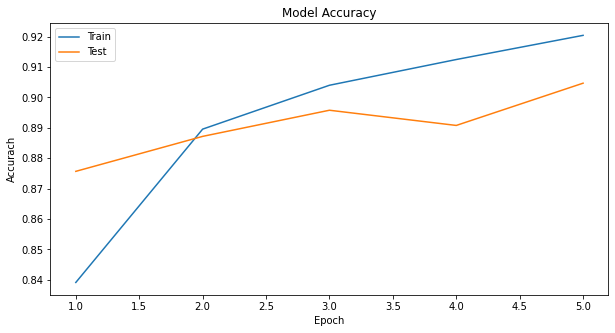

In [28]:
accuracy_curve(history, EPOCHS)

## Quiz

  - 앞선 DNN 모델 Quiz에서 layer 추가를 통해 정확도 향상 확인
  - 아래 `CNN_model` class `Conv2D` layer와 `MaxPool2D` layer를 추가하고 filter 갯수와 Epoch 수도 수정하여 정확도 높은 CNN model 만들기

### Hint
  - `self.conv2 = tk.layers.Conv2D(filters='#ofFilters', kernel_size='kernael_size(n,n)') `, 
  `self.maxpool2 = tk.layers.MaxPool2D(pool_size='pool_size(n,n)') `와 같이 새로운 convolution layer 및 pooling layer 추가 가능 

In [35]:
class CNN_model(Model):
  def __init__(self):
    super(CNN_model, self).__init__()
    self.conv1 = tk.layers.Conv2D(32, 3, activation='relu')
    self.maxpool1 = tk.layers.MaxPool2D(2)
    """
    TODO: 새로운 conv layer 정의
    """
    self.conv2 = tk.layers.Conv2D(64, 3, activation='relu')
    self.maxpool2 = tk.layers.MaxPool2D(2)
    self.flatten = tk.layers.Flatten()
    self.d1 = tk.layers.Dense(128, activation='relu')
    self.d2 = tk.layers.Dense(10)

  def call(self, x):
    x = self.conv1(x)
    x = self.maxpool1(x)
    """
    TODO: 새로운 모델 연산식 정의
    """
    x = self.conv2(x)
    x = self.maxpool2(x)
    x = self.flatten(x)
    x = self.d1(x)
    return self.d2(x)
model = CNN_model()

# loss 함수
lr = 0.001
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=lr,)

@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    predictions = model(images)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)

@tf.function
def test_step(images, labels):
  predictions = model(images)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

In [36]:
EPOCHS = 15
history = dict(
    train_loss = [],
    test_loss = [],
    train_accuracy = [],
    test_accuracy = [],
)

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()
  for images, labels in train_ds:
    train_step(images, labels)

  for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)

  print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result()}, '
    f'Accuracy: {train_accuracy.result() * 100}, '
    f'Test Loss: {test_loss.result()}, '
    f'Test Accuracy: {test_accuracy.result() * 100}'
  )
  history['train_loss'].append(train_loss.result())
  history['test_loss'].append(test_loss.result())
  history['train_accuracy'].append(train_accuracy.result())
  history['test_accuracy'].append(test_accuracy.result())

Epoch 1, Loss: 0.5127209424972534, Accuracy: 81.7066650390625, Test Loss: 0.3858628571033478, Test Accuracy: 86.20999908447266
Epoch 2, Loss: 0.3353278934955597, Accuracy: 87.84000396728516, Test Loss: 0.3290535807609558, Test Accuracy: 88.12999725341797
Epoch 3, Loss: 0.2916121780872345, Accuracy: 89.30833435058594, Test Loss: 0.30471867322921753, Test Accuracy: 88.8800048828125
Epoch 4, Loss: 0.26162153482437134, Accuracy: 90.47000122070312, Test Loss: 0.2869037687778473, Test Accuracy: 89.56999969482422
Epoch 5, Loss: 0.2354448139667511, Accuracy: 91.24333190917969, Test Loss: 0.27172642946243286, Test Accuracy: 90.02999877929688
Epoch 6, Loss: 0.21452274918556213, Accuracy: 92.14166259765625, Test Loss: 0.2707816958427429, Test Accuracy: 90.1300048828125
Epoch 7, Loss: 0.19729116559028625, Accuracy: 92.63333129882812, Test Loss: 0.2701323628425598, Test Accuracy: 90.3800048828125
Epoch 8, Loss: 0.1829875111579895, Accuracy: 93.09333801269531, Test Loss: 0.2549920678138733, Test Acc

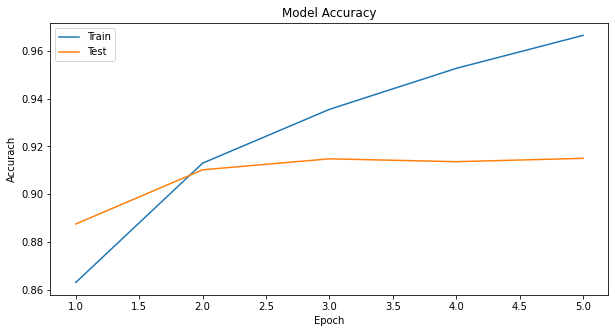

In [ ]:
accuracy_curve(history, EPOCHS)